In [55]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

np.random.seed(1)
%matplotlib inline

In [93]:
class LMSE(object):
    def _init_(self):
        self.W=None
    def train(self,x,y,lr=0.1,num_iters=2000):
        """
        x: 特征向量
        y: 标签
        lr: 学习速度
        num_iters: 迭代次数
        """
        # x.shape返回对应行、列
        num_train,num_features=x.shape
        # 返回num_train x 1的全为1的矩阵
        xone=np.ones((num_train,1))
        # 拼接成 num_train行 x列的矩阵
        x=np.column_stack((xone,x))
#         print(x)
        # print(x[np.where(y==-1)]*-1)
        # 如下涉及到具体的LMSE公式， 具体公式可参考
        #https://www.cnblogs.com/szxspark/p/9928370.html
        x[np.where(y==-1)]=x[np.where(y==-1)]*-1
#         print("\n")
#         print(x)
        #权重和偏置初始化
        self.W=np.ones((num_features+1))
        Y=x
        #逆矩阵
        Ywn=np.linalg.pinv(Y)
        bias=np.ones((num_train,))
        # 1*10的-6次方 近乎为0
        bmin=1e-6
        flag=False
        for i in range (num_iters):
            # np.dot矩阵相乘
            temp=np.array(np.dot(Y,self.W))
            # 误差矢量e
            Evector=temp-bias
            Evector_=1/2*np.add(Evector,np.absolute(Evector))
            bias=np.add(2*lr*Evector_,bias)
            self.W=np.dot(Ywn,bias)
            for row in Evector_:
                if (np.absolute(row)<=bmin):# 遇到线性不可分， 退出程序
                    print('reach bmin,end')
                    flag=True
                    break
            if flag:
                break
            
    def linear(self,x):
        return np.dot(x,self.W[1:])+self.W[0]
    
    def predict(self,x):
        return np.where(self.linear(x)>=0.0,1,-1)

In [ ]:
lmseII=LMSE()
vt=VOTER()
W=vt.train(x_train,y_train,1,lmseII)
pred=vt.predict(x_test)
acc=accuracy_score(y_test,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0,class 1','class 0,class 2','class 1,class 2']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)  
    x2 = -( w[0] +w[1]*x1) / w[2]  
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()

In [112]:
class VOTER(object):          #定义投票器包装类，该类是出于复用考虑独立出来的，
                              #需要传入分类器，只负责投票
    def _init_(self):
        self.wmatrix=[]  #分类器权重矩阵
        self.Mode=0     #定义投票器模式 0：ova 一对多（c个二类分类面），
                                   # 1：ovo（c*(c-1)/2个二类分类面） 一对一
        self.classes=None
    def train(self,x,y,mode,classifier):   #训练接口，相比一般的训练多了mode参数
                                           #和classifier参数
        matrix=[]                          
        self.Mode=mode 
        y=np.array(y)
        n_classes=np.unique(y)   #搜索到底有多少个类别    eg: unique([0,0,1,2,2])= [0,1,2]
        self.classes=n_classes
        if mode==0: #ova
            self.Mode=0
            print('training use ova vote')
            for i in n_classes:
                y_new=y              #用新的内存空间来防止误操作
                y_new=np.where(y_new==i,1,-1)   #将类标映射为目标类为正类，非目标类为负类的标准形式
                classifier.train(x,y_new)       #调用传入分类器的训练接口
                matrix.append(classifier.W)        
        else:
            if mode==1: #ovo
                self.Mode=1
                print('training use ovo vote')
                n_classes=np.unique(y)
                x=np.array(x)
                y=np.array(y)
                for i in n_classes:
                    for j in n_classes:             #类别两两组合
                        if(i>=j):
                            continue
                        y_new=y
                        y_new_i=y[np.where(y_new==i)]            #找出第i类的特征和类标
                        x_new_i=x[np.where(y_new==i)]
                        y_new_j=y[np.where(y_new==j)]            #找出第j类的特征和类标
                        x_new_j=x[np.where(y_new==j)]
                        y_new=np.concatenate((y_new_i,y_new_j),axis=0)    #第i类与第j类拼接
                        x_new=np.concatenate((x_new_i,x_new_j),axis=0)
                        y_new=np.where(y_new==i,1,-1)           #将i，j这两类映射为标准形式
                        classifier.train(x_new,y_new)          
                        matrix.append(classifier.W)
        self.wmatrix=matrix
        return matrix
    
    def predict(self,x):                                   #预测
        Wm=self.wmatrix
        vote=[]
        tim=0
        result=[]
        if self.Mode==1:                              #ovo策略的训练器进行投票
            print('using ovo mode for predicting')
            for i in self.classes:
                for j in self.classes:    #类别两两组合
                    if(i>=j):
                        continue
                    w=Wm[tim]                          
                    prediction=np.where((np.dot(x,w[1:])+w[0])>=0,i,j) #利用训练好的权重给出每个样本的类别
                    vote.append(prediction)                           #加入到投票矩阵中
                    tim+=1
            vote=np.array(vote).T                                    #投票矩阵是3*num_train的格式，要先做转置
            for line in vote:
                # 选取最大的结果
                tt=np.argmax(np.bincount(line))                     #转置后是num_train*3,也就是每个样本有3个预测结果，对结果进行投票
                result.append(tt)                                   
        else:
            if self.Mode==0:
                print('using ova mode for predicting')
                for w in self.wmatrix:
                    prediction=np.where((np.dot(x,w[1:])+w[0])>=0,1,-1)
                    vote.append(prediction)
                vote=np.array(vote).T
                for line in vote:
                    tt=np.argmax(line)                           #不统计出现个数是因为投票矩阵是的一行是[1,-1,-1]形式只要找到
                    result.append(tt)                            #正类出现的位置即可，对于同票的情况[1,1,-1]，直接以第一个
        return np.array(result)                                 #出现的正类的位置为最终决策，这是由于那些点往往是线性不可分点
                                                                #也就是没有更好的决策方式来说明该点属于哪一类。

## 算法检测

## Iris数据集 说明
**标签（品种）：** 
1. setosa
2. versicolor
3. virginica

**特征：** 
1. sepal length（花萼长度）
2. sepal width（花萼宽度） 
3. petal length（花瓣长度) 
4. petal width（花瓣宽度）


In [4]:
## 加载数据集
iris = load_iris()
## 特征
feature = iris.data

In [49]:
# 150条数据 4个特征
feature.shape

(150, 4)

In [50]:
# 标签， 介绍中的四中
target = iris.target

In [58]:
unique_tag = pd.Series(target).unique()

In [60]:
# 数据进行了简化，
# 0： setosa
# 1： versicolor
# 2： virginica
unique_tag

array([0, 1, 2])

In [63]:
# 切片展示数据， 前五条 
feature[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [64]:
# 前五条数据对应的结果为：
target[:5]

array([0, 0, 0, 0, 0])

In [66]:
# 选取第2个和第三个特征的所有数据
X = feature[:, [1,3]]

In [69]:
X[:5]

array([[3.5, 0.2],
       [3. , 0.2],
       [3.2, 0.2],
       [3.1, 0.2],
       [3.6, 0.2]])

In [19]:
y = target[:]

In [70]:
# 转化为np的array形式， 方便操作数据
label = np.array(y)

In [71]:
# setosa品种
index_0 = np.where(label==0)

In [22]:
index_0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)

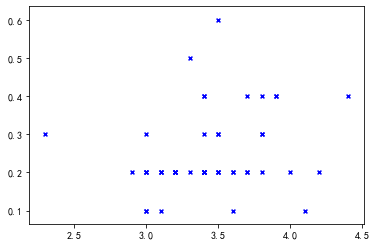

In [25]:
plt.scatter(X[index_0,0],X[index_0,1],marker='x',color = 'b',label = '0',s = 15)

In [26]:
index_1 =np.where(label==1)


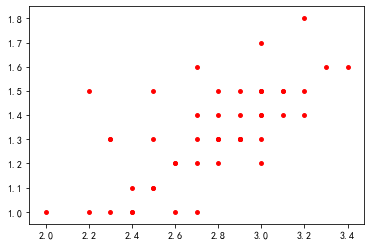

In [28]:
plt.scatter(X[index_1,0],X[index_1,1],marker='o',color = 'r',label = '1',s = 15) 


In [29]:
index_2=np.where(label==2)

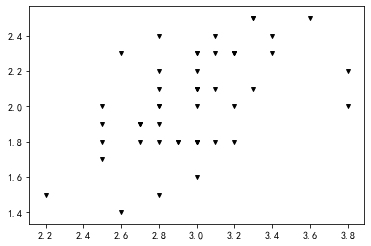

In [30]:
plt.scatter(X[index_2,0],X[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

In [74]:
y_new = y
# y_new中是0的重新复制为1， 其余的赋值为-1
# LMSE是一个二分问题， 所以需要进行转换
y_new=np.where(y_new==0,1,-1)

In [75]:
y_new

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [35]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

reach bmin,end


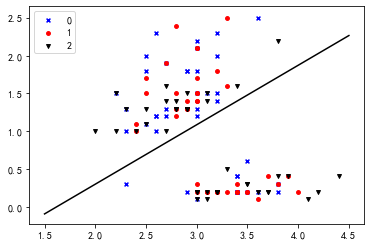

In [105]:
plt.scatter(X[index_0,0],X[index_0,1],marker='x',color = 'b',label = '0',s = 15)
plt.scatter(X[index_1,0],X[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
plt.scatter(X[index_2,0],X[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

lmse=LMSE()
lmse.train(X,y_new)
h=lmse.predict(X)
w=lmse.W
x1 = np.arange(1.5,5,0.5)
x2 = -(w[0] +w[1]*x1) / w[2]
plt.plot(x1,x2,color = 'black') 
plt.legend(loc = 'upper left')  
plt.show()

training use ovo vote
reach bmin,end
reach bmin,end
reach bmin,end
using ovo mode for predicting
the accuracy is:  0.8666666666666667


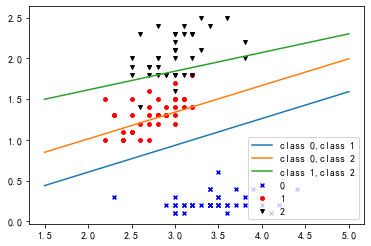

In [106]:

x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=31,stratify=y)
label=np.array(y_train)
index_0 = np.where(label==0)  
plt.scatter(x_train[index_0,0],x_train[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x_train[index_1,0],x_train[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x_train[index_2,0],x_train[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

lmseII=LMSE()
vt=VOTER()
W=vt.train(x_train,y_train,1,lmseII)
pred=vt.predict(x_test)
acc=accuracy_score(y_test,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0,class 1','class 0,class 2','class 1,class 2']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)  
    x2 = -( w[0] +w[1]*x1) / w[2]  
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()

using ovo mode for predicting


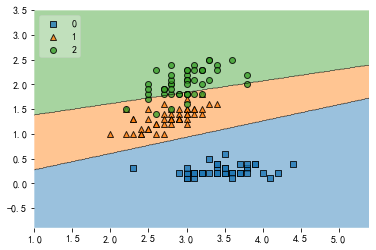

In [107]:
fig = plot_decision_regions(X=X, y=y,
                                clf=vt, legend=2)

training use ova vote
reach bmin,end
reach bmin,end
reach bmin,end
using ova mode for predicting
the accuracy is:  0.78


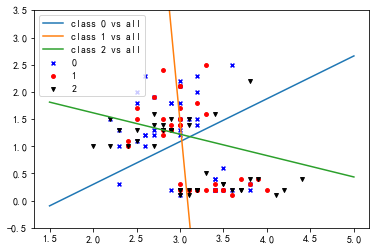

In [114]:
index_0 = np.where(label==0)  
plt.scatter(X[index_0,0],X[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(X[index_1,0],X[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(X[index_2,0],X[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

gz=LMSE()
vt=VOTER()
W=vt.train(X,y,0,gz)
pred=vt.predict(X)
acc=accuracy_score(y,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0 vs all','class 1 vs all','class 2 vs all']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)  
    x2 = -( w[0] +w[1]*x1) / w[2]
    plt.ylim(ymax=3.5)
    plt.ylim(ymin=-0.5)
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()

using ova mode for predicting


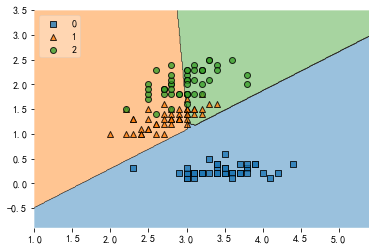

In [115]:
fig = plot_decision_regions(X=X, y=y,
                                clf=vt, legend=2)